In [156]:
import nglpy_cuda as ngl
import samply

import matplotlib.pyplot as plt
from matplotlib import patches, collections
from matplotlib.collections import LineCollection
import math
import numpy as np

from ipywidgets import interact, widgets

In [154]:
def validation_grid(resolution=20, min_x = 0, max_x = 1):
    x, y = np.mgrid[min_x:max_x:(resolution * 1j), min_x:max_x:(resolution * 1j)]
    X = np.vstack([x.ravel(), y.ravel()]).T
    return x, y, X

In [149]:
def plot_graph(X, go, ax, color):
    lines = []
    for (a, b, distance) in go:
        lines.append([(X[a,0], X[a,1]), (X[b, 0], X[b, 1])])

    line_segments = LineCollection(lines, colors=color, alpha=0.1, linestyles='-', linewidths=2, zorder=2)

    ax.scatter(X[:,0], X[:,1], c=color, s=64, zorder=3)
    ax.add_collection(line_segments)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.axis('off')
    ax.set_aspect(1)

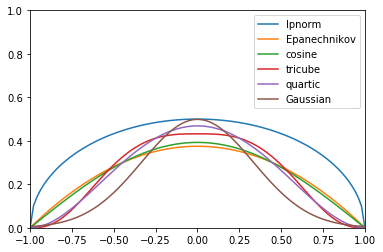

In [136]:
def Epanechnikov(u):
    return 0.5*3./4. * (1. - u**2)

def cosine(u):
    return 0.5*(math.pi/4)*np.cos(math.pi/2 * u)
    
def Gaussian(u):
    return 0.5*(5/2)*(np.exp(-0.5*(u*3)**2) / math.sqrt(2*math.pi))

def tricube(u):
    return 0.5*(70/81) * (1-np.abs(u)**3)**3

def quartic(u):
    return 0.5*(15/16) * (1 - u**2)**2

def lpnorm(u, beta=1, p=2):
    xC = 0
    yC = 0
    if beta < 1:
        r = 1 / beta
        yC = np.power(np.power(r, p) -1, 1/p)
    else:
        r = beta
        xC = 1 - beta
    y = np.power(np.power(r, p) -np.power(u-xC, p), 1 / p) - yC
    return 0.5*y

def flat(u):
    return 0*u
functions = [lpnorm, Epanechnikov, cosine, tricube, quartic, Gaussian]
fig, ax = plt.subplots(1,1)
for foo in functions:
    t = np.linspace(-1, 1, 100)
    y = foo(t)
    ax.plot(t, y, label=foo.__name__)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.legend()

(0, 1)

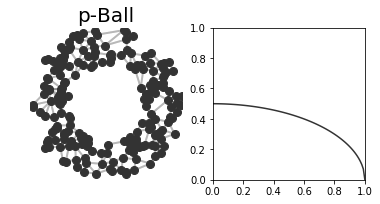

In [150]:
count = 200
dimensionality = 2
X = samply.hypercube.uniform(count, dimensionality)
X = samply.shape.shell(count, dimensionality)
go = ngl.EmptyRegionGraph(beta=1, p=2, relaxed=False, discrete_steps=100)
go.build(X)
fig, axes = plt.subplots(1,2)
plot_graph(X, go, axes[0], "#333333")
axes[0].set_title("p-Ball", fontsize=20)
t = np.linspace(0, 1, 100)
y = lpnorm(t)
axes[1].plot(t, y, c="#333333")
axes[1].set_aspect("equal")
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

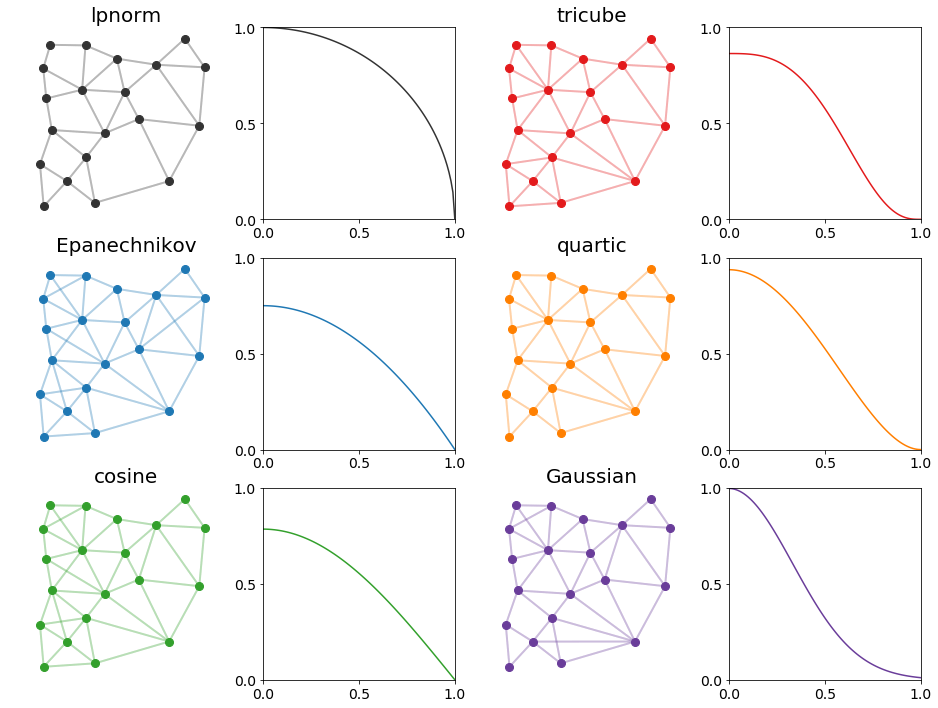

In [153]:
count = 20
dimensionality = 2
np.random.seed(1)
X = samply.hypercube.cvt(count, dimensionality)

colors = ['#333333',
          '#1f78b4',
          '#33a02c',
          '#e31a1c',
          '#ff7f00',
          '#6a3d9a',
          '#b15928']

inches=4
row_count = len(functions) // 2
fig, axes = plt.subplots(row_count, 4, figsize=(inches*4, inches*row_count))

for row, (foo, color) in enumerate(zip(functions, colors)):
    col_offset = 0 if row < row_count else 2
    row_offset = row % row_count
    go = ngl.EmptyRegionGraph(beta=1, p=2, relaxed=False, discrete_steps=100, template_function=foo)
    go.build(X)
    ax = axes[row_offset, col_offset]
    plot_graph(X, go, ax, color)
    ax.set_title(foo.__name__, fontsize=20)

    t = np.linspace(0, 1, 100)
    y = foo(t)
    ax = axes[row_offset, col_offset+1]
    ax.plot(t, 2*y, color)
    ax.set_aspect("equal")
    ax.xaxis.set_ticks([0, 0.5, 1])
    ax.yaxis.set_ticks([0, 0.5, 1])
    for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

In [157]:
@interact(beta=widgets.FloatSlider(min=0.1, max=2.0, step=0.1, value=1, continuous_update=False),
          lp=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=2, continuous_update=False),
          steepness=widgets.FloatSlider(min=1, max=20, step=0.5, value=3, continuous_update=False))
def plot_probability(beta=1, lp=2, steepness=3):
    def paired_lpnorms(A, B, p=2):
        """ Method to compute the paired Lp-norms between two sets of points. Note,
        A and B should be the same shape.

        Args:
            A (MxN matrix): A collection of points
            B (MxN matrix): A collection of points
            p (positive float): The p value specifying what kind of Lp-norm to use
                to compute the shape of the lunes.
        """
        N = A.shape[0]
        dimensionality = A.shape[1]
        norms = np.zeros(N)
        for i in range(N):
            norm = 0.0
            for k in range(dimensionality):
                norm += (A[i, k] - B[i, k])**p
            norms[i] = norm**(1./p)
        return norms


    def min_distance_from_edge(t, beta, p):
        """ Using a parameterized scale from [0,1], this function will determine
        the minimum valid distance to an edge given a specified lune shape defined
        by a beta parameter for defining the radius and a p parameter specifying
        the type of Lp-norm the lune's shape will be defined in.

        Args:
            t (float): the parameter value defining how far into the edge we are.
            0 means we are at one of the endpoints, 1 means we are at the edge's
            midpoint.
            beta (float): The beta value for the lune-based beta-skeleton
            p (float): The p value specifying which Lp-norm to use to compute
                the shape of the lunes. A negative value will be
                used to represent the inf norm

        """
        xC = 0
        yC = 0
        if t > 1:
            return 0
        if beta <= 1:
            r = 1 / beta
            yC = (r**p - 1)**(1. / p)
        else:
            r = beta
            xC = 1 - beta
        y = (r**p - (t-xC)**p)**(1. / p) - yC
        return 0.5*y

    def logistic_function(x, r):
        with np.errstate(divide="ignore"):
            k = steepness / r
            return 1 / (1 + np.exp(-k*(x - r)))

    P = np.array([[0.25, 0.25],[0.75, 0.75]])
    mid = np.average(P, axis=0)
    r = np.linalg.norm(mid - P[0])

    x, y, X = validation_grid(40)
    Z = logistic_function(np.linalg.norm(X - mid, axis=1), r)
    z = Z.reshape(x.shape)

    p = P[0]
    q = P[1]
    pq = q - p
    edge_length = np.linalg.norm(pq)
    Xp = X - p
    projections = np.dot(Xp, pq)/(edge_length**2)
    # temp_indices = np.logical_and(projections > 0., projections < 1.)
    # valid_indices = np.nonzero(temp_indices)[0]
    valid_indices = np.array(range(len(projections)))

    temp = np.atleast_2d(projections[valid_indices]).T*pq
    min_distances = np.zeros(len(valid_indices))
    for idx, t in enumerate(projections[valid_indices]):
        min_distances[idx] = min_distance_from_edge(abs(2*t-1), beta=beta, p=lp) * edge_length
    distances_to_edge = paired_lpnorms(Xp[valid_indices], temp)

    # distances_to_edge < min_distances

    Z = logistic_function(distances_to_edge, min_distances)
    z = Z.reshape(x.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=80)
    
    x1 = np.linspace(0, max(2*r,1), 100)
    y1 = logistic_function(x1, r)

    ax[0].plot(x1, y1, linewidth=4)
    ax[0].plot([min(x1), r, r], [0.5, 0.5, 0], linestyle='--', linewidth=4)
    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)
    ax[0].set_aspect('equal')
    
    contour = ax[1].contourf(x,y,z, cmap=plt.cm.cividis, vmin=0, vmax=1)
    contour2 = ax[1].contour(x,y,z, levels=[.995])
    ax[1].scatter(P[:, 0], P[:, 1], color='#ffffff')
    ax[1].plot(P[:, 0], P[:, 1], linestyle='--', color='#ffffff')
    empty_region = patches.Circle(mid, r, facecolor='none', edgecolor='#ffffff')
    ax[1].add_patch(empty_region)
    empty_region = patches.Circle(P[0], 2*r, facecolor='none', edgecolor='#ffffff')
    ax[1].add_patch(empty_region)
    empty_region = patches.Circle(P[1], 2*r, facecolor='none', edgecolor='#ffffff')
    ax[1].add_patch(empty_region)
    cb = fig.colorbar(contour, ax=ax[1], boundaries=(0,1))
    ax[1].set_xlim(0, 1)
    ax[1].set_ylim(0, 1)
    ax[1].set_aspect('equal')
    
    X = samply.hypercube.cvt(50, 2)
    graph = ngl.ProbabilisticEmptyRegionGraph(max_neighbors=20, steepness=steepness)
    graph.build(X)
    realized_edges = graph.full_graph()
    
    ax[2].scatter(X[:, 0], X[:, 1], zorder=2)
    for i in range(X.shape[0]):
        for j, prob in zip(graph.edges[i], graph.probabilities[i]):
            
            if prob > 0.75:
                linestyle = '-'
            elif prob > 0.5:
                linestyle = '-.'
            elif prob > 0.25:
                linestyle = '--'
            else:
                linestyle = ':'
            ax[2].plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], alpha=prob, c='k', linestyle=linestyle, zorder=1)
    
    ax[2].set_xlim(0, 1)
    ax[2].set_ylim(0, 1)
    ax[2].set_aspect('equal')

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='beta', max=2.0, min=0.1), F…